## Part 2 - Neural Network Implementation for Image Segmentation

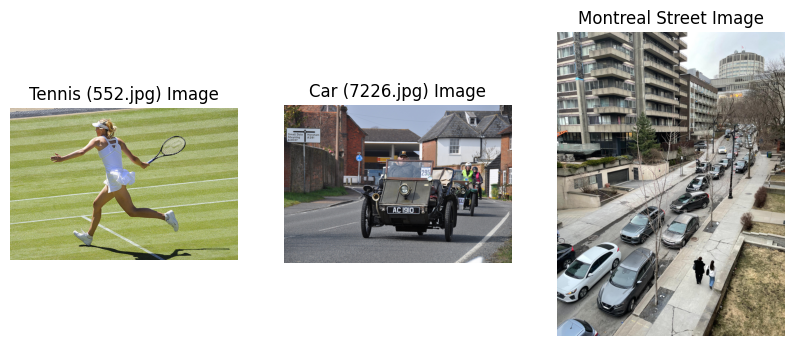

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import visualize
import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from ultralytics import YOLO

%matplotlib inline

# Uncomment for colab
# from google.colab import drive
# drive.mount('/content/drive')
# image_path = '/content/drive/My Drive/ECSE415_computer_vision/A5/'

image_path = "/Users/theog/Documents/CodingProjects/ECSE415_Computer_Vision/Assignments/A5"
tennis_image = cv2.imread(image_path + "/Part 2/000000000552.jpg")
car_image = cv2.imread(image_path + "/Part 2/000000007226.jpg")
street_image = cv2.imread(image_path + "/Part 2/image_street.jpg")

images = [tennis_image, car_image, street_image]
image_names = ['Tennis', 'Car', 'Montreal street']

# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(tennis_image, cv2.COLOR_BGR2RGB))
plt.title("Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
plt.title("Car (7226.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(street_image, cv2.COLOR_BGR2RGB))
plt.title("Montreal Street Image")
plt.axis('off')
plt.show()


### 1. Implement the pre-trained Mask R-CNN and YOLOv8n-seg model and run them on the 552.jpg and 7726.jpg image included in the assignment folder.

In [3]:
#================= Pre-trained Mask R-CNN =================
# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

transform = T.Compose([T.ToTensor()])

# List to store the predictions
predictions = []

# Loop over the images and make the predictions
for image in images:
  # Convert the image to a tensor
  image_tensor = transform(image)
  # Get the model's prediction
  with torch.no_grad():
    prediction = model([image_tensor.to(torch.float32)])
  # Add the prediction to the list
  predictions.append(prediction)

# COCO_INSTANCE_CATEGORY_NAMES provided on the RCNN github
COCO_INSTANCE_CATEGORY_NAMES = [
  '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
  'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
  'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
  'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
  'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
  'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
  'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
  'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
  'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
  'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
  'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2. Display the result that shows the bounding boxes, object classes, and segmentations inside each bounding box.


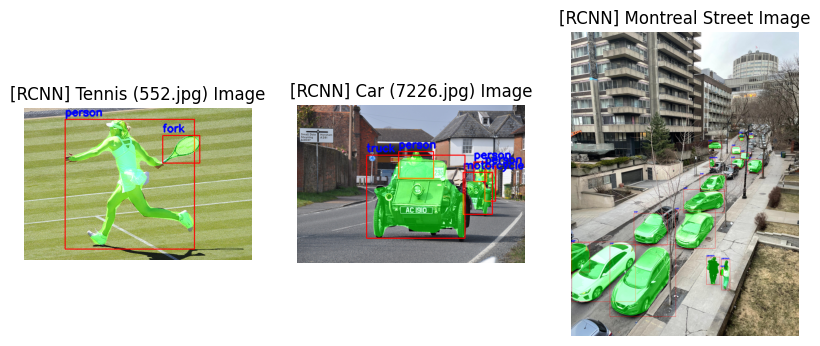

In [4]:
def create_mask(image, mask, color=(0, 255, 0)):
  mask = mask.mul(255).byte().cpu().numpy()
  color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  color_mask[mask > 128] = np.array(color, dtype=np.uint8)
  return cv2.addWeighted(image, 1, color_mask, 0.5, 0)

def draw_box(image, box, color=(0, 0, 255)):
  cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
  return image

def draw_label(image, box, label, color=(255, 0, 0)):
  cv2.putText(image, label, (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
  return image

def process_image_with_predictions(image, prediction, threshold=0.75):
  for element in range(len(prediction[0]['masks'])):
    mask = prediction[0]['masks'][element, 0]
    score = prediction[0]['scores'][element].item()
  
    if score > threshold:
      image = create_mask(image, mask)
      box = prediction[0]['boxes'][element].cpu().numpy()
      image = draw_box(image, box)
  
      label = prediction[0]['labels'][element].item()
      label_name = COCO_INSTANCE_CATEGORY_NAMES[label]
      image = draw_label(image, box, label_name)
  
  return image

labelled_tennis_image = process_image_with_predictions(tennis_image, predictions[0])
labelled_car_image = process_image_with_predictions(car_image, predictions[1])
labelled_street_image = process_image_with_predictions(street_image, predictions[2])


# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(labelled_tennis_image, cv2.COLOR_BGR2RGB))
plt.title("[RCNN] Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(labelled_car_image, cv2.COLOR_BGR2RGB))
plt.title("[RCNN] Car (7226.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(labelled_street_image, cv2.COLOR_BGR2RGB))
plt.title("[RCNN] Montreal Street Image")
plt.axis('off')
plt.show()

In [5]:

!pip install ultralytics
!pip install onnxruntime-gpu  # For GPU support
!pip install numpy
!pip install opencv-python

!yolo export model=yolov8s-seg.pt imgsz=640 format=onnx opset=12 simplify

DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Invalid requirement: '#'


DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Ultralytics YOLOv8.1.27 ðŸš€ Python-3.10.11 torch-2.2.1+cu121 CPU (11th Gen Intel Core(TM) i9-11900H 2.50GHz)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

PyTorch: starting from 'yolov8s-seg.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 116, 8400), (1, 32, 160, 160)) (22.8 MB)

ONNX: starting export with onnx 1.16.0 opset 12...
ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success âœ… 2.7s, saved as 'yolov8s-seg.onnx' (45.2 MB)

Export complete (5.3s)
Results saved to C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\Assignments\A5
Predict:         yolo predict task=segment model=yolov8s-seg.onnx imgsz=640  
Validate:        yolo val task=segment model=yolov8s-seg.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
ðŸ’¡ Learn more at https://docs.ultralytics.com/modes/export


In [6]:
# Load a pretrained YOLO model
model = YOLO('yolov8s-seg.pt')
detected_images=[]
for image in images:
  results = model.predict(image)
  result=results[0]
  detected_images.append(result.plot())

# Extract segemented images
detected_image_street = detected_images[2]
detected_image_car = detected_images[1]
detected_image_tennis = detected_images[0]

# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(detected_image_tennis, cv2.COLOR_BGR2RGB))
plt.title("[YOLOv8] Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(detected_image_car, cv2.COLOR_BGR2RGB))
plt.title("[YOLOv8] Car (7226.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(detected_image_street, cv2.COLOR_BGR2RGB))
plt.title("[YOLOv8] Montreal Street Image")
plt.axis('off')
plt.show()

NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:440 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at ..\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at ..\aten\src\ATen\FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at ..\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ..\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ..\aten\src\ATen\native\NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at ..\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at ..\torch\csrc\autograd\TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ..\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ..\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ..\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ..\aten\src\ATen\functorch\TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:158 [backend fallback]


### 4. Compare the performance of these two models and explain the steps that Mask R-CNN took to achieve the final result.


We can determine the following from the pictures and the results:
- Tennis image:
  - Mask R-CNN: The model was able to detect the tennis racket and the person holding it. However, it mislabelled the tennis racket for a "Fork"
  - YOLOv8: The model was able to detect the tennis racket and the person holding it. And it labelled everything correctly
- Car image:
  - Mask R-CNN: The model was able to detect the cars. However it mislabelled 
  - YOLOv8: The model was able to detect the tennis racket and the person holding it. And it labelled everything correctly
- Montreal Street image:
  - Mask R-CNN: The model was able to detect the tennis racket and the person holding it. However it mislabelled 
  - YOLOv8: The model was able to detect the tennis racket and the person holding it. And it labelled everything correctly